In [1]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [2]:
import math
import copy
import cv2
import pandas as pd
import numpy as np
import random
from shutil import copyfile
from pathlib import Path
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from ml_helpers.image_helpers import display_images
from ml_helpers.common_helpers import display_history_metrics

from sklearn.model_selection import train_test_split
import pickle

from kaggle_problems.rosneft_proppant.workspace.common import bins

from kaggle_problems.rosneft_proppant.workspace.common import TARGET_SHAPE
from kaggle_problems.rosneft_proppant.workspace.common import prop_size2r, bin2low, bin2high

In [3]:
COLORED_IMG_DIR = "kaggle_problems/rosneft_proppant/data/colored_main_area"
BW_IMG_DIR = "kaggle_problems/rosneft_proppant/data/bw_main_area"

sieves_names = [6,7,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,100]
sieves_names = [str(i) for i in sieves_names]

sive_diam = [3.35,2.8, 2.36, 2, 1.7, 1.4, 1.18, 1, 0.85, 0.71, 0.6, 0.5, 0.425, 0.355, 0.3, 0.25, 0.212, 0.18, 0.15]
sive_diam = np.array(sive_diam)


In [4]:
colored_img = [img[:-len(".jpg")] for img in os.listdir(COLORED_IMG_DIR) if img.endswith('.jpg')]
bw_img = [img[:-len(".jpg")] for img in os.listdir(BW_IMG_DIR) if img.endswith('.jpg')]

In [5]:
train = pd.read_csv("kaggle_problems/rosneft_proppant/workspace/data/labels/train.csv")

In [6]:
bw_train = train[train.ImageId.isin(bw_img)]
bw_train = bw_train[~bw_train.prop_count.isna()]
bw_train = bw_train[~bw_train['18'].isna()]

In [7]:
def get_bw_prop_count(img, bins):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    #splt.imshow(threshed, cmap='gray')
    s = np.sum(threshed == 255)
    pred_s = 0
    
    for b, diam in zip(sieves_names, sive_diam):
        persent = float(bins[b])
        if persent > 1e-5:
            r = (bin2low[b] + bin2high[b]) / 2
            #print(persent, r)
            pred_s += (r ** 2) * math.pi * persent
    
    return s / pred_s

In [9]:
diff = []
for img_number in bw_train.ImageId:
    print(img_number)
    img = cv2.imread("{}/{}.jpg".format(BW_IMG_DIR, img_number))
    bins = bw_train[bw_train['ImageId'].isin([img_number])]
    
    real_prop_count = float(bins['prop_count'])
    bins = bins[sieves_names]
    
    pred_prop_count = get_bw_prop_count(img, bins)
    diff.append(real_prop_count - pred_prop_count)
    if (real_prop_count - pred_prop_count < -1000):
        print("min:", img_number)
        
    if (real_prop_count - pred_prop_count > 400):
        print("max:", img_number)

41
(4305, 2595, 3)
42
(4305, 2595, 3)
47
(4305, 2595, 3)
73
(4305, 2595, 3)
100
(4305, 2595, 3)
min: 100
112
(4305, 2595, 3)
151
(4305, 2595, 3)
152
(4305, 2595, 3)
179
(4305, 2595, 3)
191
(4305, 2595, 3)
214
(4305, 2595, 3)
215
(4305, 2595, 3)
227
(4305, 2595, 3)
237
(4305, 2595, 3)
308
(4305, 2595, 3)
348
(4305, 2595, 3)
max: 348
416
(4305, 2595, 3)
424
(4305, 2595, 3)
440
(4305, 2595, 3)
492
(4305, 2595, 3)
496
(4305, 2595, 3)
524
(4305, 2595, 3)
max: 524
553
(4305, 2595, 3)
592
(4305, 2595, 3)
616
(4305, 2595, 3)
655
(4305, 2595, 3)
714
(4305, 2595, 3)


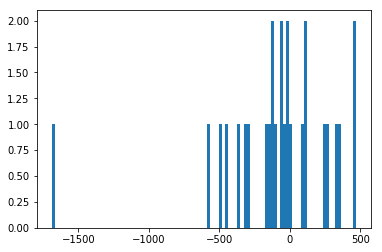

In [143]:
plt.hist(diff, bins=100)
plt.show()

In [139]:
np.mean(diff)

0.10934066535604547